In [1]:
import matplotlib.pyplot as plt

from model.modeling_llama import LlamaForCausalLM as ModifiedLlama
from transformers import AutoTokenizer, AutoModelForCausalLM
from kvcache.iterative import IterativeReduceKVBiasCache as ModifiedCache, IterativeReduceKVBiasCache
from transformers import DynamicCache
from datasets import load_dataset

import torch
import numpy as np
import random

import torch.nn.functional as F
import time
from IPython.display import DisplayHandle

import os
import random
import pandas as pd

import seaborn as sns

DEVICE = 'mps'
DTYPE = torch.float32
FIRST_N = 1000
SAMPLE_SIZE = 1
MAX_LENGTH = 500

In [2]:
# Define the cache file name
CACHE_FILENAME = f"fineweb_sample{SAMPLE_SIZE}of{FIRST_N}.csv"

# Check if the cache file already exists
if os.path.exists(CACHE_FILENAME):
    print(f"Cache file already exists: {CACHE_FILENAME}")
    df = pd.read_csv(CACHE_FILENAME)
else:
    # Load streaming dataset
    dataset = load_dataset("HuggingFaceFW/fineweb-edu", split="train", name="sample-10BT", streaming=True)
    stream = iter(dataset)

    # Take 1000 streamed samples
    samples = [next(stream) for _ in range(1000)]

    # Randomly select 10 of them
    selected_samples = random.sample(samples, SAMPLE_SIZE)

    # Convert to DataFrame
    df = pd.DataFrame(selected_samples)

    # Save to CSV
    df.to_csv(CACHE_FILENAME, index=False, encoding="utf-8")
    print(f"Saved CSV with {len(df)} samples to: {CACHE_FILENAME}")

texts = df["text"]

Resolving data files:   0%|          | 0/2110 [00:00<?, ?it/s]

Saved CSV with 1 samples to: fineweb_sample1of1000.csv


In [8]:
def get_cache_size(cache: DynamicCache | ModifiedCache, max_len: int):
    n_layers = len(cache.key_cache)
    n_heads = len(cache.key_cache[0][0])
    
    if isinstance(cache, DynamicCache):
        for layer in range(n_layers):
            for head in range(n_heads):
                yield {'Layer ID': layer, 'Head ID': head, 'Cache Size (% of max)': 100}
    else:
        for layer, last_available_per_head in enumerate(cache.last_available_idx):
            last_available_per_head = last_available_per_head[0]
            for head, last_available in enumerate(last_available_per_head):
                yield {'Layer ID': layer, 'Head ID': head, 'Cache Size (% of max)': 100 * (last_available.item() / max_len)}
                
                

def stepwise_perplexity(model, tokenizer, texts, cache_impl, update_every=10, max_length=MAX_LENGTH):
    loss_fn = torch.nn.CrossEntropyLoss()

    total_texts = len(texts)

    display_handle = DisplayHandle()
    display_handle.display("Starting perplexity evaluation...")
    
    # track: PPL, Text Idx, Step, Cache Class
    results = []
    
    # track: Cache Size (% of max), Layer ID, Head ID, Text Idx, Step
    results_cache = []

    for text_idx, text in enumerate(texts):
        enc = tokenizer(text, return_tensors="pt", truncation=True, max_length=max_length)
        input_ids = enc["input_ids"].squeeze(0).to(model.device)
        cache = cache_impl()
        
        if isinstance(cache, ModifiedCache):
            cache_class = cache.__class__.__name__ + f"(MVI={cache.max_variance_increase:.1f})"
        else:
            cache_class = cache.__class__.__name__
        
        seq_len = input_ids.size(0)
        
        total_loss = 0.0
        total_tokens = 0

        # Autoregressive token-by-token loop
        for i in range(1, seq_len):
            input_slice = input_ids[i - 1 : i].unsqueeze(0)  # [1, 1]
            label_token = input_ids[i].unsqueeze(0)          # [1]

            with torch.no_grad():
                output = model(
                    input_ids=input_slice,
                    use_cache=True,
                    past_key_values=cache,
                )
                cache = output.past_key_values
                logits = output.logits[:, -1, :]  # [1, vocab_size]
                loss = loss_fn(logits, label_token)
                total_loss += loss.item()
                total_tokens += 1

            # Update the display every update_every steps
            if total_tokens % update_every == 0 or (i == seq_len - 1 and text_idx == total_texts - 1):
                current_ppl = np.exp(total_loss / total_tokens)
                status = (f"Text {text_idx + 1}/{total_texts} | "
                          f"Token {i + 1}/{seq_len} | "
                          f"Global Steps: {total_tokens} | "
                          f"Cumulative PPL: {current_ppl:.2f}")
                display_handle.update(status)
            
            # Append current results:
            # For each token, we collect the current perplexity estimate, the cache class, 
            # the text index, and the current step number.
            results.append({
                "PPL": np.exp(total_loss / total_tokens),
                "Cache Class": cache_class,
                "Text Idx": text_idx,
                "Step": i
            })
            
            results_cache.extend([
                {
                    "Text Idx": text_idx,
                    "Step": i,
                    "Cache Class": cache_class,
                    **d
                }
                for d in get_cache_size(cache, max_len=i + 1)  
            ])

    return results, results_cache

In [9]:
def plot(data):
    plt.figure(figsize=(12, 7))
    sns.lineplot(y="PPL", x="Step", data=pd.DataFrame(data), hue="Cache Class")
    plt.ylim((0, 40))
    
    
def plot_cache(data):
    plt.figure(figsize=(12, 7))
    sns.lineplot(y="Cache Size (% of max)", x="Step", data=pd.DataFrame(data), hue="Cache Class")

In [10]:
#texts = [texts[0]]

In [11]:
model_hf = AutoModelForCausalLM.from_pretrained("HuggingFaceTB/SmolLM2-135M")
model_hf.eval().to(DEVICE).to(DTYPE)

tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM2-135M")

'Text 1/1 | Token 500/500 | Global Steps: 499 | Cumulative PPL: 10.64'

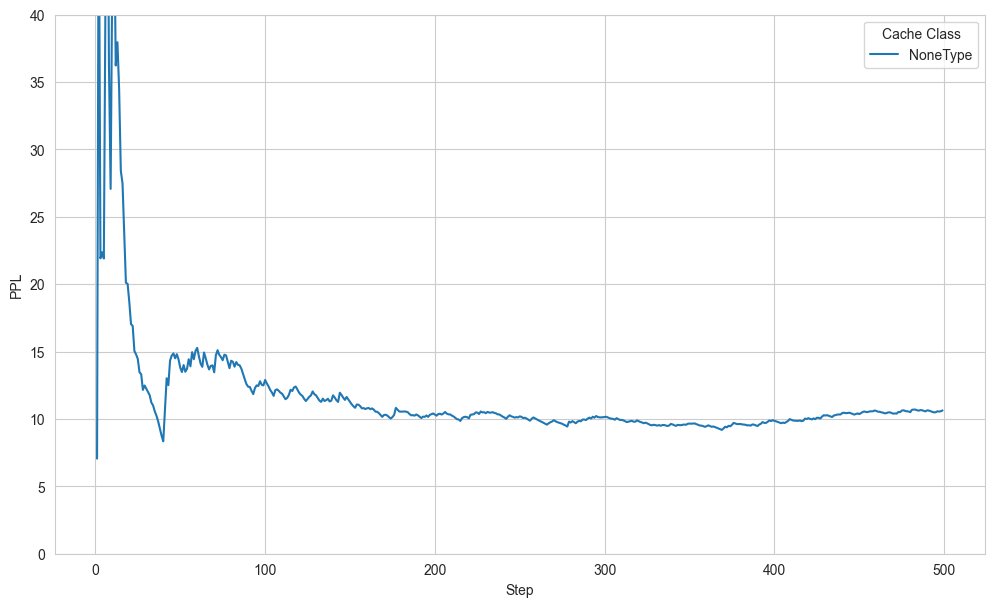

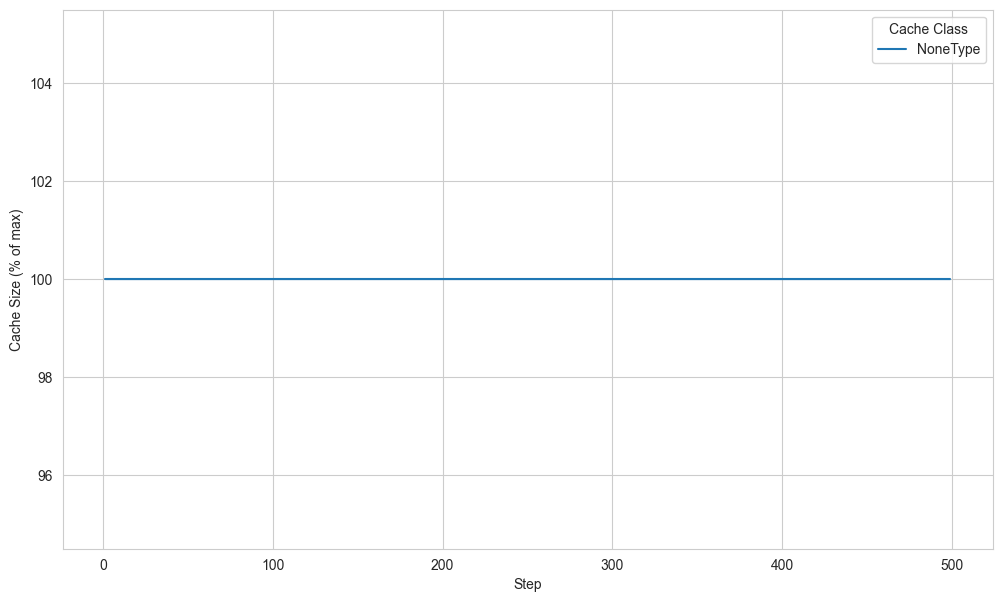

In [12]:
results, results_cache = stepwise_perplexity(model_hf, tokenizer, texts, cache_impl=lambda: None)
plot(results)
plot_cache(results_cache)

In [13]:
model_mod = ModifiedLlama.from_pretrained("HuggingFaceTB/SmolLM2-135M")
model_mod.eval().to(DEVICE).to(DTYPE)

tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM2-135M")

In [ ]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, cache_impl=lambda: ModifiedCache(max_variance_increase=0.0))
results += res
results_cache += resc
plot(results)
plot_cache(results_cache)

'Text 1/1 | Token 81/500 | Global Steps: 80 | Cumulative PPL: 14.32'

In [ ]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, cache_impl=lambda: ModifiedCache(max_variance_increase=1.0))
results += res
results_cache += resc
plot(results)
plot_cache(results_cache)

In [ ]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, cache_impl=lambda: ModifiedCache(max_variance_increase=5.0))
results += res
results_cache += resc
plot(results)
plot_cache(results_cache)

In [ ]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, cache_impl=lambda: ModifiedCache(max_variance_increase=10.0))
results += res
results_cache += resc
plot(results)
plot_cache(results_cache)

In [ ]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, cache_impl=lambda: ModifiedCache(max_variance_increase=20.0))
results += res
results_cache += resc
plot(results)
plot_cache(results_cache)